# TCAE_performance_on_test_set

We trained a time prediction model on [Active Matter microscopy videos](https://www.youtube.com/watch?v=aJrB5MMPqhA&ab_channel=ThomsonLab) for 100 epochs (we focused only on isolated microtubule networks organized by polygonal light patterns). See `next_frame_pred_no_arms_02.py`, which is the script containing the training details.

---
In the following notebook, we will explore and evaluate the predictions on the test dataset made by our TCAE model.

This notebook reproduces **Figure3**, which can be found in our paper: [Linear Transformations in Autoencoder Latent Space Predict Time Translations in Active Matter System](https://openreview.net/forum?id=ZDBDTHSoMDU).

---

In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import tqdm
from TCAE import *
from helper_functions import *
from image_processing_functions import *
from skimage.measure import label as label_connected_areas

experiment_name = "next_frame_pred_no_arms_02"

base_dir = os.path.join(os.getcwd(),experiment_name)
weights_dir = os.path.join(base_dir,'weights')
whole_vid_pred_images_dir = os.path.join(base_dir,'whole_vid_pred')
gif_dir = os.path.join(base_dir,'gif')

# Create Directories to save results
create_dir(whole_vid_pred_images_dir)
create_dir(gif_dir)

In [2]:
# Instantiate model
latent_dim = 2048
tcae = TConvAutoEncoder(latent_dim)
# Load weights
# A 'dummy' forward pass is necessary to 'connect' model.
tcae((np.zeros((1,112,112,1), dtype = 'float32'), 
      np.zeros((1,1), dtype = 'float32'))
); 
# Select weigths with best validation loss
tcae.load_weights(sorted(glob.glob(weights_dir + '/*'))[2])

In [3]:
# Let's load some data to see the model's predictions
start_frame = 30
end_frame = 180
video_length = abs(start_frame - end_frame)
input_height = 112
input_width = 112
input_channels = 1

file_list = glob.glob("/home/ubuntu/am-cvae/data/112x112_pulse/*")
file_list_val = [file for file in file_list if "rec600" in file ]
val_data = np.load(file_list_val[0])[start_frame:end_frame]
val_data = np.expand_dims(val_data, -1).astype("float32")

## Perceptual comparison: Prediction of future and past time points vs ground truth data.

Let's show an example of predictions on the test dataset made by the TCAE. For computing predictions, we will first code a function that can take one initial frame as input and then plot our TCAE predictions along with Ground Truth data. 

In [4]:
def plot_perceptual_comparison(data, initial_frame, max_dt, n_im, figsize):
    '''
    Plot predictions along with Ground Truth images. 
    Top row contains TCAE predictions. Bottom row contains GT data.

    Args:
    data (numpy array): numpy array with GT data. shape = (n, height, width, channels)
    initial_frame (int): index for input frame.
    max_dt (int): Maximum change in time to predict.
    n_im (int): number of images per row. (equal to number of columns)
    figsize (tuple): Matplotlib figure size.
    '''
    cols = n_im
    rows = 2
    dt_array = np.linspace(0,max_dt,num = n_im)
    plt.figure(figsize = figsize)
    for i, dt in enumerate(dt_array):
        prediction = tcae.predict(
            (data[initial_frame:initial_frame+1], 
             np.array([[dt]], dtype = 'float32'))
        ) 
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(prediction[0,:,:,0])
        plt.axis("off")
        ax.set_title(f't = {initial_frame + dt}', fontsize = 10)
    for i, dt in enumerate(dt_array):
        ax = plt.subplot(rows, cols, n_im + i+1)
        plt.imshow(data[initial_frame + int(dt),:,:,0])
        plt.axis("off")

We will take as input the frame at time t = 50 and evenly spaced Δt's lying in the interval (0,  60). Our output are TCAE predictions at t = inital_t + Δt.

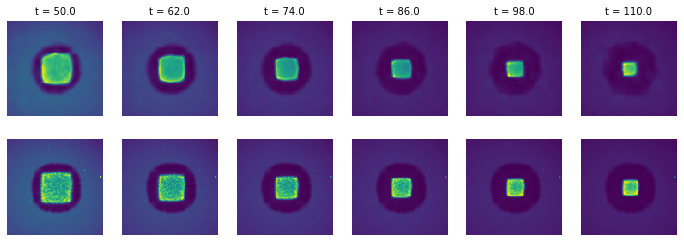

In [5]:
# Top row contains TCAE predictions
# Bottom row contains GT data
plot_perceptual_comparison(
    data = val_data, 
    initial_frame = 50, 
    max_dt = 60,
    n_im = 6,
    figsize = (12,4)
)

Although in the training phase, we constrained ∆t to take positive values between 0 and 20, the time embedding Φ can be scaled by negative values, namely time translation in the opposite direction. Here we recapitulate the past of a single observation a time t = 120, using Δt's lying in the interval (0, -32).

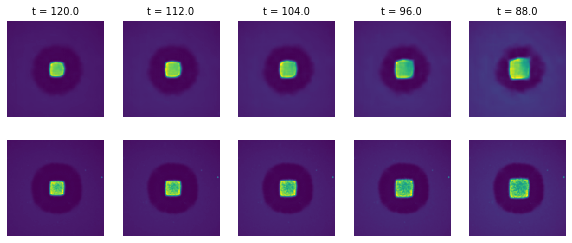

In [6]:
# Top row contains TCAE predictions
# Bottom row contains GT data
plot_perceptual_comparison(
    data = val_data, 
    initial_frame = 120, 
    max_dt = -32,
    n_im = 5,
    figsize = (10,4)
)

## Whole video prediction
Given that we can move in either time direction in the latent space, TCAE can perform whole video predictions from a single given frame.


We will take all single frames from the test video and compute whole video prediction by only varying $\Delta t$.

Let `video_length` = n. We will do the following mapping using our TCAE: (where `Xt` represents the input frame at time t, and `X̃t+dt` is the predicted frame at time t+dt).

$$(\mathbf{X}_{t = 0}, \Delta t \in \{0,1,2,\ldots,n-1\}) \mapsto 
\{\tilde{\mathbf{X}}_{t = 0},\tilde{\mathbf{X}}_{t = 1}, \tilde{\mathbf{X}}_{t = 2}, \ldots, \tilde{\mathbf{X}}_{t = n-1} \}$$

$$(\mathbf{X}_{t = 1}, \Delta t \in \{-1,0,1,\ldots,n-2\}) \mapsto 
\{\tilde{\mathbf{X}}_{t = 0},\tilde{\mathbf{X}}_{t = 1}, \tilde{\mathbf{X}}_{t = 2}, \ldots, \tilde{\mathbf{X}}_{t = n-1} \}$$

$$(\mathbf{X}_{t = 2}, \Delta t \in \{-2,1,0,\ldots,n-3\}) \mapsto 
\{\tilde{\mathbf{X}}_{t = 0},\tilde{\mathbf{X}}_{t = 1}, \tilde{\mathbf{X}}_{t = 2}, \ldots, \tilde{\mathbf{X}}_{t = n-1} \}$$

$$\vdots$$

$$(\mathbf{X}_{t = i}, \Delta t \in \{-i,-i+1,-i+2,\ldots,(n-1)-i\}) \mapsto 
\{\tilde{\mathbf{X}}_{t = 0},\tilde{\mathbf{X}}_{t = 1}, \tilde{\mathbf{X}}_{t = 2}, \ldots, \tilde{\mathbf{X}}_{t = n-1} \}$$

$$\vdots$$

$$(\mathbf{X}_{t = n-1}, \Delta t \in \{-(n-1),-(n-1)+1,-(n-1)+2,\ldots,0\}) \mapsto 
\{\tilde{\mathbf{X}}_{t = 0},\tilde{\mathbf{X}}_{t = 1}, \tilde{\mathbf{X}}_{t = 2}, \ldots, \tilde{\mathbf{X}}_{t = n-1} \}$$

See that we will predict n videos with length n.

**Note:** *We are using zero-based indexing.* <br>

In [7]:
n = video_length
# Array to save our results, the total number of predicted samples is n squared.
video_predictions = np.zeros(shape=(n**2, input_height,input_width,input_channels))
# We will store all dt's needed in a single ordered array: [-(n-1),-(n_1)+1,...,0,...,n-2,n-1]
dt_array = np.arange(-(n-1), n, dtype = "float32")
# Array with time embedding scaled by all dt's: [-(n-1)(Φ), -(n_1)+1(Φ),...,0(Φ),...,n-2(Φ),n-1(Φ)]
time_embeddings =  tcae.time_embedding.predict(dt_array)
# Xt -> zt, Images in AM video to image embeddings
image_embeddings = tcae.encoder.predict(val_data)
# For all initial frames:
for i in tqdm.tqdm(range(image_embeddings.shape[0])):
    # Slicing of `time_embeddings` is a sliding window to the left starting at the end of the array.
    # zt + ΔtΦ, Time-translation in latent space
    translated_embeddings = image_embeddings[i:i+1] + time_embeddings[(n-1)-i:len(dt_array)-i]
    # Populate results array with predictions, (zt + ΔtΦ) -> X̃t+Δt
    video_predictions[n*i:n*(i+1),:,:] = tcae.decoder.predict(translated_embeddings)

100%|██████████| 150/150 [00:19<00:00,  7.85it/s]


Now that we have computed all possible whole video predictions from single frames, we can visualize one as an example by plotting the individual predicted frames and displaying them using an animated GIF:

In this specific case our input frame has t = 60, and Δt is in [-60, -59, -58,..,0,..,87, 88, 89] (the video length is equal to 150).

In [8]:
input_frame = 60
for frame in tqdm.tqdm(range(n)):
    dts = dt_array[(n-1)-input_frame:len(dt_array)-input_frame]
    fig = plt.figure()
    ax1 = plt.subplot(1,2,1)
    plt.imshow(val_data[frame,:,:,0])
    plt.axis('off')
    plt.title(f'GT: t = {frame}')
    ax2 = plt.subplot(1,2,2)
    plt.imshow(video_predictions[(n*input_frame)+frame,:,:,0])
    plt.axis('off')
    plt.title(f'pred: input = {input_frame}, dt = {dts[frame]}')
    plt.savefig(
        os.path.join(whole_vid_pred_images_dir, f"whole_vid_pred_{str(frame).zfill(4)}"), 
        bbox_inches='tight',
        pad_inches=0.1,
    )
    plt.close()

100%|██████████| 150/150 [00:14<00:00, 10.30it/s]


In [9]:
gif_whole_vid_path = os.path.join(gif_dir,'tcae_whole_vid_pred.gif')
create_gif(gif_whole_vid_path, whole_vid_pred_images_dir)

100%|██████████| 150/150 [00:02<00:00, 67.50it/s]



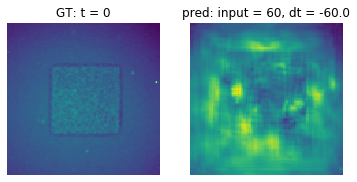

In [10]:
embed.embed_file(gif_whole_vid_path)

## Quantification of the microtubule network's area: Whole video prediction vs. Ground Truth

We can evaluate the microtubule network's size evolution. Let's take the past and future dynamics of a single image at t = 75. We will use thresholding to segment the microtubule network and quantify its area on prediction and ground truth data.

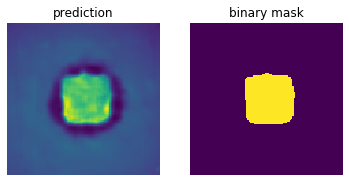

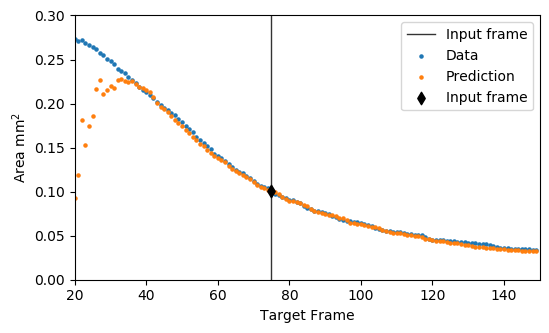

In [11]:
input_frame = 75
# Segmentation of microtubule network
mask_pred = thresholding(video_predictions[n*input_frame:n*(input_frame+1),:,:,:], method='triangle')
mask_pred = remove_objects(mask_pred, min_size=100)
mask_gt = thresholding(val_data, method='triangle')
mask_gt = remove_objects(mask_gt, min_size=100)
mask_gt = mask_gt.astype('int')

# Plot segmentation results
plt.subplot(1,2,1)
plt.imshow(video_predictions[n*input_frame:n*(input_frame+1),:,:,:][50,:,:,0])
plt.axis('off')
plt.title('prediction')
plt.subplot(1,2,2)
plt.imshow(mask_pred[50,:,:,0])
plt.axis('off');
plt.title('binary mask')
plt.show()

# Let's quantify the area of the binary masks
area_pred = count_pixels(mask_pred)
area_gt = count_pixels(mask_gt)
# Interpixel distance = .65 μm^2
# Images were downsampled from 2048x2048px --> 112x112px
# 1mm^2 = 1x10^6 μm^2 
true_area_pred = area_pred * .65**2 * ((2048/112)**2) * 1e-6
true_area_gt = area_gt * .65**2 * ((2048/112)**2) * 1e-6

# Plot area quantification results
plt.figure(dpi = 100, figsize= (6,3.5))
plt.scatter(range(video_length), true_area_gt, s =5 , label = 'Data')
plt.scatter(range(video_length), true_area_pred, s = 5, label = 'Prediction')
# diamond at input_frame
plt.scatter(input_frame, true_area_gt[input_frame], s = 40, c = 'k', marker = "d", label = 'Input frame')
# vertical line at input_frame
plt.plot([input_frame]*2, np.linspace(0,1, num=2), c = 'k', label = 'Input frame', linewidth = 1,alpha = .8)
plt.ylim(0,.3)
plt.xlim(20,150)
plt.xlabel("Target Frame")
plt.ylabel("Area mm$^2$")
plt.legend()
plt.show()

## Shape mismatch analysis in all whole video predictions

We define a simple metric to evaluate the shape mismatch between the ground truth and the predicted segmented (binary) images. The normalized mismatch index ε is defined by:

$$\epsilon(\mathbf{X}_{\text{TCAE}},\mathbf{X}_{\text{GT}}) = \frac{\sum \text{vec}(\mathbf{X}_{\text{TCAE}}) \oplus  \text{vec}(\mathbf{X}_{\text{GT}})}{\sum \text{vec}(\mathbf{X}_{\text{GT}})}$$

Where: `XTCAE` is the binary mask of a predicted image, `XGT` is the binary mask of a GT image, `vec` is the vectorization transformation, and `⊕` is the bitwise XOR operation.


First, we have to segment all the whole video predictions, using our previous segmentation pipeline:

**Note:** *we will remove poorly segmented frames such as those that contain more than one disconnected area.*

In [12]:
mask_video_predictions = thresholding(video_predictions, method='triangle')
mask_video_predictions = remove_objects(mask_video_predictions, min_size=100)
mask_video_predictions = mask_video_predictions.reshape(video_length,video_length,input_height,input_width)
# label disconnected areas
for input_frame in tqdm.tqdm(range(mask_video_predictions.shape[0])):
    for pred_frame in range(mask_video_predictions.shape[1]):
        labeled_areas = label_connected_areas(mask_video_predictions[input_frame, pred_frame], connectivity=2)
        # "remove" predictions with more than one disconnected area
        if labeled_areas.max() > 1:
            mask_video_predictions[input_frame, pred_frame] = np.zeros((input_height,input_width))

100%|██████████| 150/150 [00:04<00:00, 32.44it/s]


The intuition behind using the bitwise XOR operation in our normalized mismatch index is that XOR computes the mismatch area between two binary masks.

Let's look at the following example:

Here we take the whole video prediction computed using input frame t = 47, and we are only focusing our attention on the output frame t = 54.

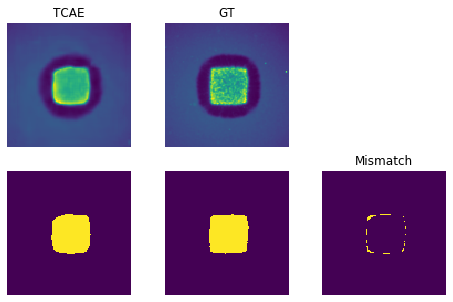

In [13]:
input_frame = 47
target_frame = 54 # target
fig = plt.figure(figsize = (8,5))
ax1 = plt.subplot(2,3,1)
plt.imshow(video_predictions[(n*input_frame)+target_frame,:,:,0])
plt.axis('off')
plt.title(f'TCAE')
ax2 = plt.subplot(2,3,2)
plt.imshow(val_data[target_frame,:,:,0])
plt.title(f'GT')
plt.axis('off')
ax3 = plt.subplot(2,3,4)
plt.imshow(mask_video_predictions[input_frame,target_frame,:,:])
plt.axis('off')
ax4 = plt.subplot(2,3,5)
plt.imshow(mask_gt[target_frame,:,:,0])
plt.axis('off')
ax5 = plt.subplot(2,3,6)
# Compute mismatch area:
mismatch = np.bitwise_xor(
    mask_gt[target_frame,:,:,0], 
    mask_video_predictions[input_frame,target_frame,:,:],
)
plt.imshow(mismatch)
plt.axis('off')
plt.title('Mismatch');

Now that we have segmented all the whole video predictions, we will compute the normalized mismatch index using every predicted frame and its corresponding GT image. The normalized mismatch index values will be stored in a heatmap. Each row in the heatmap is an individual comparison between a predicted video and the GT video. The error value for the frame used as input lies on the main diagonal (reconstruction error), and the rest of the error values for the predictions of the past and future frames lie on the row containing the input frame.

In [14]:
heatmap = np.zeros((video_length,video_length))
mask_gt_vectors = mask_gt.reshape((video_length,input_height*input_width))
true_areas = np.sum(mask_gt_vectors, axis = -1).astype('float32')
true_areas[np.where(true_areas == 0)] += 1e-6 # Add a small number to avoid dividing by zero
for input_frame in range(mask_video_predictions.shape[0]):
    mask_pred_vectors = mask_video_predictions[input_frame].reshape((video_length,input_height*input_width))
    mismatch_vectors = np.bitwise_xor(mask_gt_vectors, mask_pred_vectors)
    mismatch_index = np.sum(mismatch_vectors, axis = -1)/true_areas
    heatmap[input_frame] = mismatch_index

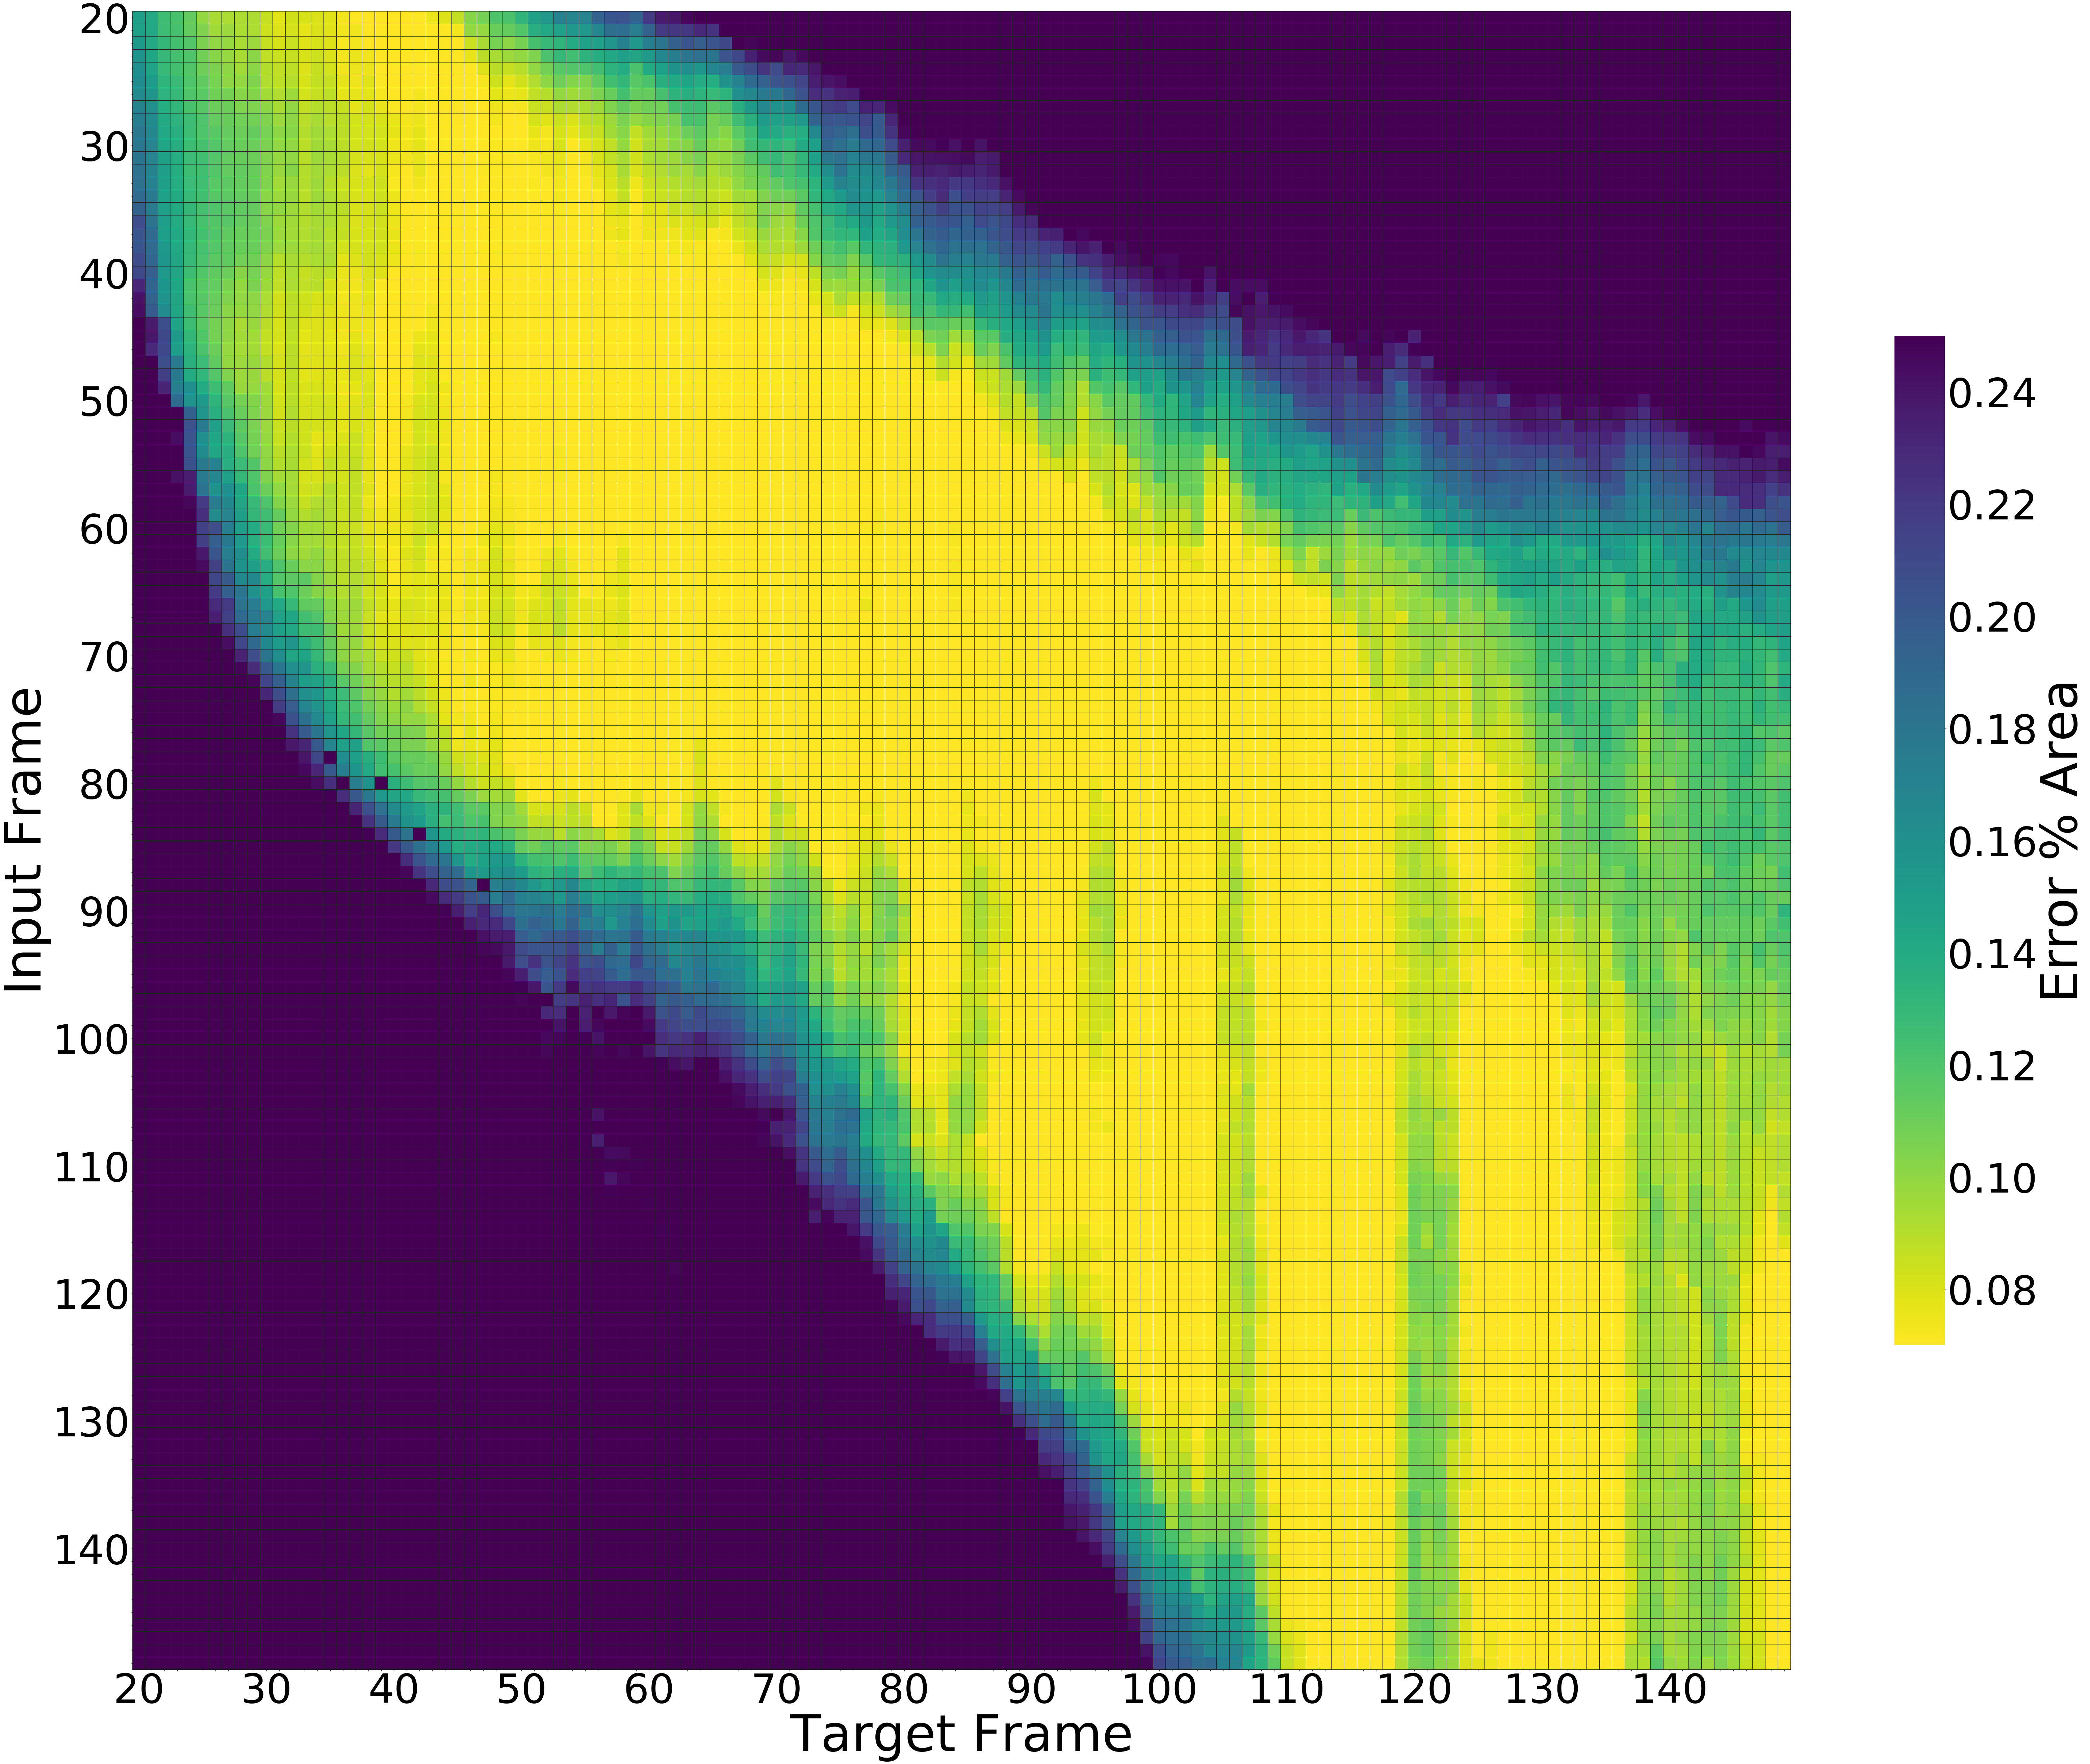

In [15]:
fig, ax = plt.subplots(figsize=(110,110))  
start = 20
end = 150
ax = sns.heatmap(
    heatmap[start:end, start:end], 
    vmin=0.07, 
    vmax=.25,
    cmap = 'viridis_r',
    linewidth=0.01,  # Add gridlines
    linecolor="222",
    square=True,
    cbar=True,
    xticklabels = [i  if i %10 == 0 else "" for i in range(start,end)],
    yticklabels = [i  if i %10 == 0 else "" for i in range(start,end)],
    cbar_kws={"shrink": 0.5, 'label': 'Error % Area', },
)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 120);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 120, rotation = 0);
ax.figure.axes[-1].yaxis.label.set_size(150)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=120)
plt.xlabel("Target Frame", fontsize = 150)
plt.ylabel("Input Frame", fontsize = 150);